## Alinging raster DEM to sparse altimetry points 
#### Adapted from the [ASP Documentation](https://stereopipeline.readthedocs.io/en/latest/tools/pc_align.html#pc-align)
##### For best results, first run the `example-dem_corigestration.ipynb` tutorial, and follow the notes there. This will make interpreting the contents of the current tutorial easier :) 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import requests
import numpy as np
import pandas as pd
import os,sys,glob
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shutil import which
import geopandas as gpd
import dask
import zipfile
from pyproj import Proj, transform
import subprocess
from fetch_dem import opentopo_utils
import asp_binder_utils as asp_utils
import xyzservices
import rioxarray
import rasterio
from shapely.geometry import box
from sliderule import sliderule, icesat2
import contextily as ctx

import xyzservices

## Universal settings

In [17]:
terrain_map = xyzservices.providers.Esri.WorldImagery() #Used to render basemap
#verbose = False #  Will only print the bash commands and whether the process ran sucessfully or not
verbose = True # will print all the logs printed by ASP
alignment_algorithm = 'point-to-point' # suggested to use point-to-point if the terrain variability is low (more flat terrain cases) and when using altimetry points
max_displacement = 40 #you might have to play with this to adapt to different datasets
tsrs = 'EPSG:32611' # input projection
tr = 30 #DEM resolution

## Study Site
* Our study area for this tutorial located in Providence Mountains, California, USA.
* The site has limited seasonal elevation change, and limited vegetation presence.
* We provide the study area extent in the github repository through this geojson file (`providence_mountains_small.geojson`)

In [5]:
aoi_box = gpd.read_file('providence_mountains_small.geojson')
aoi_extent = aoi_box.total_bounds
aoi_box.explore(tiles=terrain_map)

## Preprocessing 0: Data Download

* For the purpose of this tutorial, we will register ALOS World 30 m (AW3D30_E) DEM downloaded using the opentopgraphy api to sparse elevation values derived by the [ICESat-2 altimetry mission](https://icesat-2.gsfc.nasa.gov/).
    * More information on the AW3D30_E data can be found [here](https://portal.opentopography.org/datasetMetadata?otCollectionID%253DOT.112016.4326.2).
    * We will download ICESat-2 using the [Sliderule Earth](https://slideruleearth.io/web/) package.


* Alternatively, users can bring their own source DEM, and explore the tutorial using the same! Please follow the below guidelines to do so.
    * To perform this in a github codespace session, go to the file explorer on the right, do a right click and select upload, then upload the DEMs of your choice from the file browser.
    * See also this [stack exhange answer](https://stackoverflow.com/questions/62284623/how-can-i-upload-a-file-to-a-github-codespaces-environment)
    * When you change the DEMs to a different site than the site used by default, make sure to change the projected corrdinate system definition (tsrs) in the Universal Settings tab above. 

### 0.1 Download AW3D30_E DEM

In [6]:
opentopo_api_key = 'demoapikeyot2022' #replace with your open topgraphy apikey here

geo_crs = 'EPSG:4326'

dem_fn = opentopo_utils.get_dem('AW3D30_E',aoi_extent,apikey=opentopo_api_key,proj=tsrs)

Deleting existing DEM file with same name as AW3D30_E.tif
https://portal.opentopography.org/API/globaldem?demtype=AW3D30_E&west=-115.52704215217467&south=34.87494635467863&east=-115.49273343095588&north=34.9235421982971&outputFormat=GTiff&API_Key=demoapikeyot2022
OK!
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -s_srs 'EPSG:4326' -t_srs 'EPSG:32611' AW3D30_E_temp.tif AW3D30_E.tif
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -s_srs 'EPSG:4326' -t_srs 'EPSG:32611' AW3D30_E_temp.tif AW3D30_E.tif
Creating output file that is 111P x 187L.
Processing AW3D30_E_temp.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image AW3D30_E_temp.tif.
Copying nodata values from source AW3D30_E_temp.tif to destination AW3D30_E.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
/srv/conda/envs/notebook/bin/gdal_edit.py AW3D30_E.tif -a_srs EPSG:32611+EPSG:4979


Child returned 0
Child returned 0


### 0.2 Query ICESat-2 points over DEM extent

In [7]:
sliderule.earthdata.set_max_resources(1000)
region = sliderule.toregion(aoi_box)
# Build ATL06 Request Parameters
parms = {
    "poly": region["poly"],
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 7.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    
}

# Make ATL06 Request
atl06 = icesat2.atl06p(parms) #dataframe with ICESat-2 points over the study area

In [8]:
atl06.shape
print(f"The query returned {len(atl06)} points over the study site, let's plot them to get a sense of their distribution")

The query returned 2423 points over the study site, let's plot them to get a sense of their distribution


In [9]:
## Plot ICESat-2 points over the aoi
atl06.reset_index()[['geometry','h_mean']].explore(column='h_mean',style_kwds=dict(fill=False),tiles=terrain_map)

### 0.3 Coordinate system transformation
* ICESat-2 points from sliderule are in ITRF2014 Coordinate Reference System (CRS), while our DEM is in WGS84 CRS.
* We will use CRS transformation in geopandas to transform the ICESat-2 points into the WGS84 CRS.

In [10]:
atl06.crs

<Geographic 3D CRS: EPSG:7912>
Name: ITRF2014
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: International Terrestrial Reference Frame 2014
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
wgs84_projection = 'EPSG:4326'+'EPSG:4979'
atl06_epsg_4326 = atl06.to_crs(epsg="4326+4979")

In [12]:
atl06_epsg_4326.crs

<Geographic 3D CRS: EPSG:4979>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 0.4 Save ICESat-2 points to disk for alignment purposes 

In [14]:
atl06_epsg_4326['lon'] = atl06_epsg_4326.geometry.x
atl06_epsg_4326['lat'] = atl06_epsg_4326.geometry.y
altimetry_csv_fn_all = 'ICESat-2_all_control_points.csv'
atl06_epsg_4326[['lon','lat','h_mean']].to_csv(altimetry_csv_fn_all,index=False)

## 1. Perform Co-registration (using ASP's [pc_align](https://stereopipeline.readthedocs.io/en/latest/tools/pc_align.html) algorithm)

In [18]:

pc_align = which('pc_align')
ref_alitmetry = altimetry_csv_fn_all
src_dem = dem_fn
alignment_dir  = 'alignment_sparse_altimetry_all/dem_aligned2ICESat2'
#csv_proj4 = '+proj=longlat +ellps=GRS80 +no_defs +type=crs' #EPSG:7912 (https://epsg.io/7912#google_vignette)
csv_proj4 = '+proj=longlat +datum=WGS84 +no_defs +type=crs' #EPSG:4326 https://epsg.io/4326#google_vignette
altimetry_datum = 'WGS84'
csv_format = '1:lon,2:lat,3:height_above_datum'
alignment_call = f"{pc_align}  --compute-translation-only --highest-accuracy  --csv-format '{csv_format}' --csv-proj4 '{csv_proj4}' --save-inv-transformed-reference-points --alignment-method {alignment_algorithm}  --max-displacement {max_displacement} {src_dem} {ref_alitmetry} -o {alignment_dir}"
asp_utils.run_bash_command(alignment_call,verbose=verbose)

/srv/StereoPipeline/bin/pc_align  --compute-translation-only --highest-accuracy  --csv-format '1:lon,2:lat,3:height_above_datum' --csv-proj4 '+proj=longlat +datum=WGS84 +no_defs +type=crs' --save-inv-transformed-reference-points --alignment-method point-to-point  --max-displacement 40 AW3D30_E.tif ICESat-2_all_control_points.csv -o alignment_sparse_altimetry_all/dem_aligned2ICESat2
	--> Setting number of processing threads to: 4
Writing log info to: alignment_sparse_altimetry_all/dem_aligned2ICESat2-log-pc_align-03-13-2108-5495.txt
Detected datum from AW3D30_E.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the referenc

writing to alignment_sparse_altimetry_all/dem_aligned2ICESat2-iterationInfo.csv


Match ratio: 0.75031
Alignment took 0.010494 [s]
Number of errors: 2423
Output: error percentile of smallest errors (meters): 16%: 0.107874, 50%: 0.384404, 84%: 0.94313
Output: mean of smallest errors (meters): 25%: 0.0849556, 50%: 0.178674, 75%: 0.293445, 100%: 0.860164
Final error computation took 0.006842 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 0.0142391100525856
                 0                  1                  0 -2.380225916393101
                 0                  0                  1 0.2894542263820767
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(-2255149.8,-4727329.7,3629316.2)
Centroid of source points (lat,lon,z): Vector3(34.899353,-115.50325,1051.0643)

Translation vector (Cartesian, meters): Vector3(0.01423911,-2.3802259,0.28945423)
Translation vector (North-East-Down, meters): Vector3(-0.98821442,1.0376872,-1.922524

Child returned 0


## Important observations
* Note we used the `point-to-point` alignment algorithm instead of the `point-to-plane` algorithm, which is preffered when using spare points for alignment. 
* Also note that while we are aligning the 30 m DEM to the ICESat-2 points, we passed in the DEM as the reference, and used `-save-inv-transformed-reference-points` option. This is because pc_align works best with a denser point cloud as reference. The `-save-inv-transformed-reference-points` flag then applies the inverse of the transformation to the DEM data, which gives us the DEM point cloud aligned to the ICESat-2 points :) 
* The other observations are similar from the DEM to DEM alignment tutorial 

### 1.1 Grid the output DEM

In [20]:
point2dem = which('point2dem')
tsrs = tsrs
#p2dem_args = '--errorimage'
nodata_value = -9999.0
pointcloud = glob.glob(alignment_dir+'*-trans_reference.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call  = f"{point2dem} --tr {tr} --t_srs '{tsrs}' --nodata-value {nodata_value} {pointcloud}"
asp_utils.run_bash_command(point2dem_call,verbose=verbose)
aligned_dem = glob.glob(alignment_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(aligned_dem))

Gridding pointcloud alignment_sparse_altimetry_all/dem_aligned2ICESat2-trans_reference.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32611' --nodata-value -9999.0 alignment_sparse_altimetry_all/dem_aligned2ICESat2-trans_reference.tif
	--> Setting number of processing threads to: 4
Writing log info to: alignment_sparse_altimetry_all/dem_aligned2ICESat2-trans_reference-log-point2dem-03-13-2113-7353.txt
The point cloud files must have an equal number of channels which must be 4 or 6 to be able to remove outliers.
Statistics: [********************************************************] Complete!
QuadTree: [**********************************************************] Complete!
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(108,183) px.
Writing: alignment_sparse_altimetry_all/dem_aligned2ICESat2-trans_reference-DEM.tif
DEM: [**************************************************************

Child returned 0


## 2. Compute difference of between pointclouds

### 2.1 Initial DEM and altimetry difference

In [21]:
geodiff = which('geodiff')
initial_output_prefix = 'initial'
print(f"Computing elevation difference before alignment between {ref_alitmetry} and {src_dem}\n\n")
geodiff_call = f"{geodiff} {ref_alitmetry} {src_dem} --csv-format {csv_format} --csv-proj4 '{csv_proj4}' -o {initial_output_prefix}"
asp_utils.run_bash_command(geodiff_call,verbose=verbose)
initial_elevation_difference_fn = glob.glob(initial_output_prefix+'-diff.csv')[0]
print("\n\nInitial elevation difference saved at {}".format(initial_elevation_difference_fn))

Computing elevation difference before alignment between ICESat-2_all_control_points.csv and AW3D30_E.tif


/srv/StereoPipeline/bin/geodiff ICESat-2_all_control_points.csv AW3D30_E.tif --csv-format 1:lon,2:lat,3:height_above_datum --csv-proj4 '+proj=longlat +datum=WGS84 +no_defs +type=crs' -o initial
	--> Setting number of processing threads to: 4
	Found input nodata value for DEM: -9999
Max difference:       7.0548 meters
Min difference:       -10.1016 meters
Mean difference:      -2.00427 meters
StdDev of difference: 0.936129 meters
Median difference:    -2.01407 meters
Writing difference file: initial-diff.csv


Initial elevation difference saved at initial-diff.csv


Child returned 0


### 2.2 Final DEM and altimetry difference

In [22]:
geodiff = which('geodiff')
final_output_prefix = 'final'
print(f"Computing elevation difference before alignment between {ref_alitmetry} and {aligned_dem}\n\n")
geodiff_call = f"{geodiff} {ref_alitmetry} {aligned_dem} --csv-format {csv_format} --csv-proj4 '{csv_proj4}' -o {final_output_prefix}"
asp_utils.run_bash_command(geodiff_call,verbose=verbose)
final_elevation_difference_fn = glob.glob(final_output_prefix+'-diff.csv')[0]
print("\n\nFinal elevation difference saved at {}".format(initial_elevation_difference_fn))

Computing elevation difference before alignment between ICESat-2_all_control_points.csv and alignment_sparse_altimetry_all/dem_aligned2ICESat2-trans_reference-DEM.tif


/srv/StereoPipeline/bin/geodiff ICESat-2_all_control_points.csv alignment_sparse_altimetry_all/dem_aligned2ICESat2-trans_reference-DEM.tif --csv-format 1:lon,2:lat,3:height_above_datum --csv-proj4 '+proj=longlat +datum=WGS84 +no_defs +type=crs' -o final
	--> Setting number of processing threads to: 4
	Found input nodata value for DEM: -9999
Max difference:       10.3635 meters
Min difference:       -8.15224 meters
Mean difference:      -0.0172514 meters
StdDev of difference: 1.08714 meters
Median difference:    -0.0549164 meters
Writing difference file: final-diff.csv


Final elevation difference saved at initial-diff.csv


Child returned 0


## Plot results

/srv/conda/envs/notebook/lib/python3.9/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


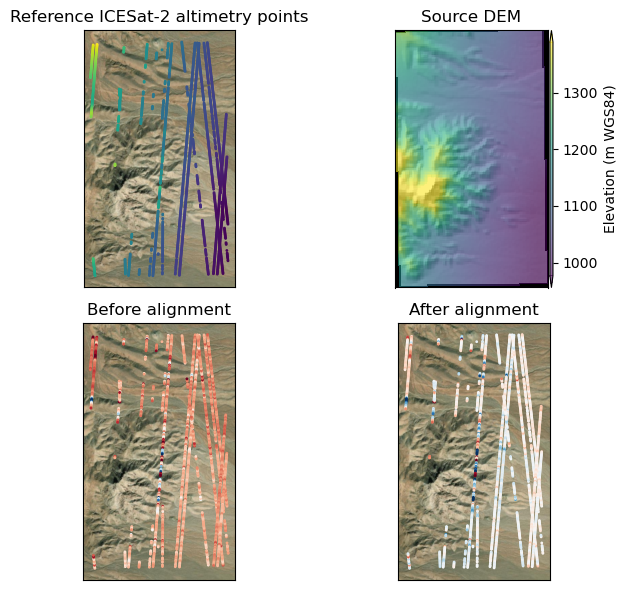

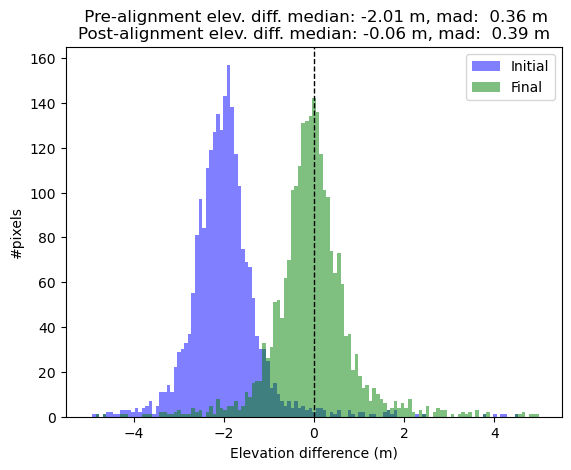

In [23]:
asp_utils.plot_alignment_maps_altimetry(atl06_epsg_4326,src_dem,initial_elevation_difference_fn,final_elevation_difference_fn,plot_crs=tsrs)

### Some observations
* Note after the alignment, the bias of ~2 m is removed!